In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
df = pd.read_csv("Data_Analytics_Task.csv")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_19744\1056596955.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data_Analytics_Task.csv")


In [3]:
# First 5 rows dekhne ke liye
print(df.head())
print(df.info())

   expert_id  team_lead_id  user_id India vs NRI medicalconditionflag funnel  \
0    4158219         57319    88612        India                  Yes    Bot   
1    3204022         57319   220396        India                  Yes    Bot   
2    7505333       4409298   648533        India                  Yes     FT   
3     888689         57319   682607        India                   No    Bot   
4    7542742       1140109  2259628        India                  Yes    Bot   

            event_type current_status      handled_time   slot_start_time  \
0  Booked Consultation           Done  22-01-2019 14:22  22-01-2019 10:30   
1  Booked Consultation           Done  29-12-2018 18:43  29-12-2018 17:45   
2  Booked Consultation           Done  11-12-2018 16:24  11-12-2018 15:45   
3  Booked Consultation     Didnt Pick  28-12-2018 16:03  28-12-2018 15:30   
4  Booked Consultation           Done  08-01-2019 14:56  05-01-2019 13:30   

  booked_flag      payment_time target_class  
0      Bo

In [4]:
# DateTime format convert karna
df['slot_start_time'] = pd.to_datetime(df['slot_start_time'])
df['payment_time'] = pd.to_datetime(df['payment_time'], errors='coerce')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19744\3126324514.py:2: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['slot_start_time'] = pd.to_datetime(df['slot_start_time'])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19744\3126324514.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['payment_time'] = pd.to_datetime(df['payment_time'], errors='coerce')


In [5]:
# Naya column: Conversion hua ya nahi
df['converted'] = np.where(df['payment_time'].notnull(),1,0)

In [6]:
def conversion_within_days(x, days):
    return ((x['payment_time'] - x['slot_start_time']).dt.days <= days) & (x['converted'] == 1)

df['conversion_3d'] = conversion_within_days(df, 3)
df['conversion_7d'] = conversion_within_days(df, 7)


In [7]:
# work on a copy
df2 = df.copy()

df2.columns = df2.columns.str.strip().str.lower().str.replace(' ', '_')

if 'lead_type' not in df2.columns:
    if 'india_vs_nri' in df2.columns:
        df2 = df2.rename(columns={'india_vs_nri': 'lead_type'})
    else:
        fallback = None
        for cand in ['medicalconditionflag', 'target_class', 'booked_flag', 'user_id']:
            if cand in df2.columns:
                fallback = cand
                break
        if fallback:
            df2['lead_type'] = df2[fallback].astype(str)
        else:
            raise KeyError("No suitable column found to use as 'lead_type'. Please tell me which column should be used.")

# Ensure required time columns exist
required = ['slot_start_time', 'payment_time', 'funnel']
missing = [c for c in required if c not in df2.columns]
if missing:
    raise KeyError(f"Missing required column(s): {missing}. Available columns: {df2.columns.tolist()}")

# Convert to datetime
df2['slot_start_time'] = pd.to_datetime(df2['slot_start_time'], errors='coerce')
df2['payment_time']    = pd.to_datetime(df2['payment_time'], errors='coerce')

# how many missing datetimes
print("Missing slot_start_time:", df2['slot_start_time'].isna().sum())
print("Missing payment_time   :", df2['payment_time'].isna().sum())

df2['delta_days'] = (df2['payment_time'] - df2['slot_start_time']).dt.days


df2['conversion_3d'] = np.where(df2['delta_days'].notna() & (df2['delta_days'] >= 0) & (df2['delta_days'] <= 3), 1, 0)
df2['conversion_7d'] = np.where(df2['delta_days'].notna() & (df2['delta_days'] >= 0) & (df2['delta_days'] <= 7), 1, 0)


conversion_stats = (
    df2.groupby(['funnel', 'lead_type'])[['conversion_3d', 'conversion_7d']]
    .mean()
    .reset_index()
)

print(conversion_stats)




Missing slot_start_time: 0
Missing payment_time   : 70120
  funnel lead_type  conversion_3d  conversion_7d
0    Bot     India       0.039215       0.044914
1    Bot       NRI       0.055566       0.061955
2    Bot     Other       0.006289       0.012579
3     FT     India       0.021704       0.024846
4     FT       NRI       0.037602       0.043822
5     FT     Other       0.001745       0.003490


In [8]:
# Slot hour nikalna
df['hour'] = df['slot_start_time'].dt.hour


In [9]:
# Har hour me conversion rate
hourly_sales = df.groupby('hour')['converted'].mean().reset_index()

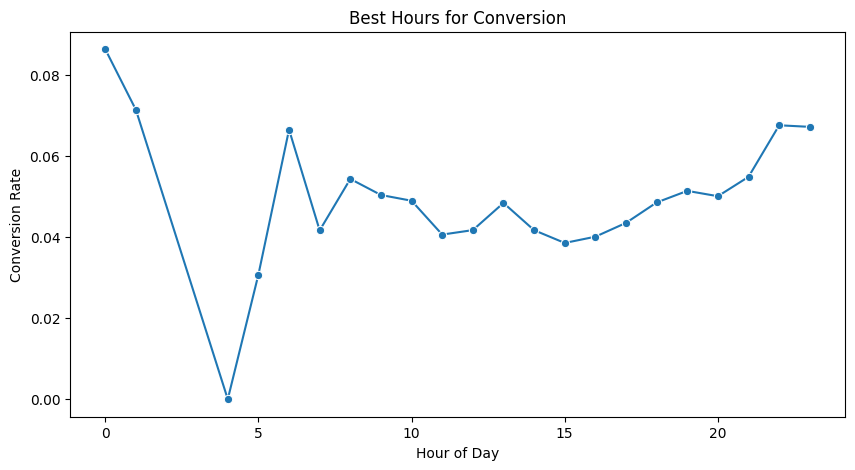

In [10]:
plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_sales, x='hour', y='converted', marker='o')
plt.title("Best Hours for Conversion")
plt.xlabel("Hour of Day")
plt.ylabel("Conversion Rate")
plt.show()

In [11]:
coach_performance = df.groupby('target_class')['converted'].mean().reset_index()

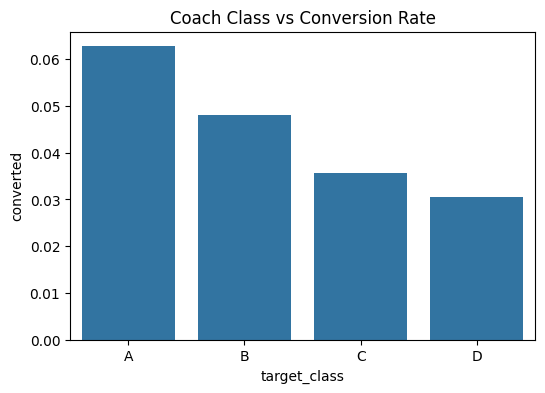

In [12]:
plt.figure(figsize=(6,4))
sns.barplot(data=coach_performance, x='target_class', y='converted', order=['A','B','C','D'])
plt.title("Coach Class vs Conversion Rate")
plt.show()

In [13]:
df.columns

Index(['expert_id', 'team_lead_id', 'user_id', 'India vs NRI',
       'medicalconditionflag', 'funnel', 'event_type', 'current_status',
       'handled_time', 'slot_start_time', 'booked_flag', 'payment_time',
       'target_class', 'converted', 'conversion_3d', 'conversion_7d', 'hour'],
      dtype='object')

In [14]:
# Country type comparison
country_insights = df.groupby('India vs NRI')['converted'].mean().reset_index()
country_insights.rename(columns={'converted': 'conversion_rate'}, inplace=True)

print("Conversion by Country Type:\n", country_insights)

Conversion by Country Type:
   India vs NRI  conversion_rate
0        India         0.043125
1          NRI         0.067571
2        Other         0.013661


In [15]:
# Funnel wise total conversions
funnel_insights = df.groupby('funnel')['converted'].mean().reset_index()
print("Conversion by Funnel:\n", funnel_insights)


Conversion by Funnel:
   funnel  converted
0    Bot   0.061693
1     FT   0.033533


In [16]:
print("🔹 Recommendations:")
print("1. Focus on Funnel + Lead Types with higher 7-day conversion.")
print("2. Run campaigns during peak conversion hours:", hourly_sales.sort_values('converted', ascending=False).head(3))
print("3. Assign high-value leads to 'A' & 'B' coaches for max sales.")
print("4. Consider special strategy for NRI vs India leads depending on performance.")

🔹 Recommendations:
1. Focus on Funnel + Lead Types with higher 7-day conversion.
2. Run campaigns during peak conversion hours:     hour  converted
0      0   0.086379
1      1   0.071429
20    22   0.067609
3. Assign high-value leads to 'A' & 'B' coaches for max sales.
4. Consider special strategy for NRI vs India leads depending on performance.
